<h1><Center>Part 2: Feature Engineering and model development<center></h1>
<br>
<br>

<small>
This notebook is a continuation of <a href="01_feature_extraction_data_exploration.ipynb">01_feature_extraction_data_exploration.ipynb (Part 1)</a>.<br><br>

In this notebook (Part 2), I will develop a machine learning model to predict whether input features extracted from an audio file are AI-generated or not. The process includes feature selection, feature engineering, model training, testing, and hyperparameter tuning.
</small>


In [1]:
#getting data from the csv file created in the first notebook
import pandas as pd # type: ignore
df = pd.read_csv(r'data\audio_data.csv')
df.head()
X = df.drop(['file_id', 'label'], axis=1, inplace=False)
y = df['label']

<h4>baseline accuracy</h4>
<small>Setting a simple linear regression model as baseline

In [2]:
#setting baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from src.mc_validation import mc_validation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scaled_X = scaler.fit_transform(X)
lr_baseline_model = LogisticRegression()
mc_validation(lr_baseline_model, Scaled_X, y, 5000)

mean accuracy: 0.7447389477895578
standard deviation of scores: 0.085327504486991


(np.float64(0.7447389477895578), np.float64(0.085327504486991))

## Feature Selection and Engineering

As shown in the correlation heatmap in [the first notebook](01_feature_extraction_data_exploration.ipynb), many predictive features are highly correlated with each other — especially the various metrics related to formant values.

To address this, I will use two main methods to reduce the dataset’s dimensionality:  
- **Feature engineering via Principal Component Analysis (PCA)**  
- **Feature selection using Point-Biserial Correlation testing**

PCA is particularly effective for models like Naive Bayes, which can be sensitive to multicollinearity. However, it may not be worth the information loss for Support Vector Machines, which tend to be more robust to correlated features.
<br><br>
<hr>


<h3>Principle Component Analysis</h3>

I will begin by applying Principal Component Analysis (PCA) to reduce the dataset’s dimensionality. Many features overlap in the information they convey, although each may capture some unique variation.

For example, `f1_mean`, `f1_min`, and `f1_max` all summarize the same time-series formant data extracted from each audio file; similarly for `f2`, `f3`, and `f1_f2_ratio_mean`.

Using PCA lets me mitigate multicollinearity for algorithms that are sensitive to correlated inputs, while preserving the most meaningful variations in the data.


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA, keeping components to exlpain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("explained variance ratio: ", pca.explained_variance_ratio_)
print("cumulative variance:", pca.explained_variance_ratio_.cumsum())
print(f"original feature count: {len(X.columns)}")
print(f"number of components: {pca.n_components_}")

explained variance ratio:  [0.23440453 0.17786111 0.11000385 0.10410618 0.06185777 0.04735127
 0.03845875 0.03681003 0.03353261 0.0274764  0.02650126 0.0193675
 0.01873966 0.01698809]
cumulative variance: [0.23440453 0.41226564 0.52226949 0.62637567 0.68823344 0.73558471
 0.77404346 0.81085348 0.8443861  0.8718625  0.89836376 0.91773126
 0.93647093 0.95345902]
original feature count: 26
number of components: 14


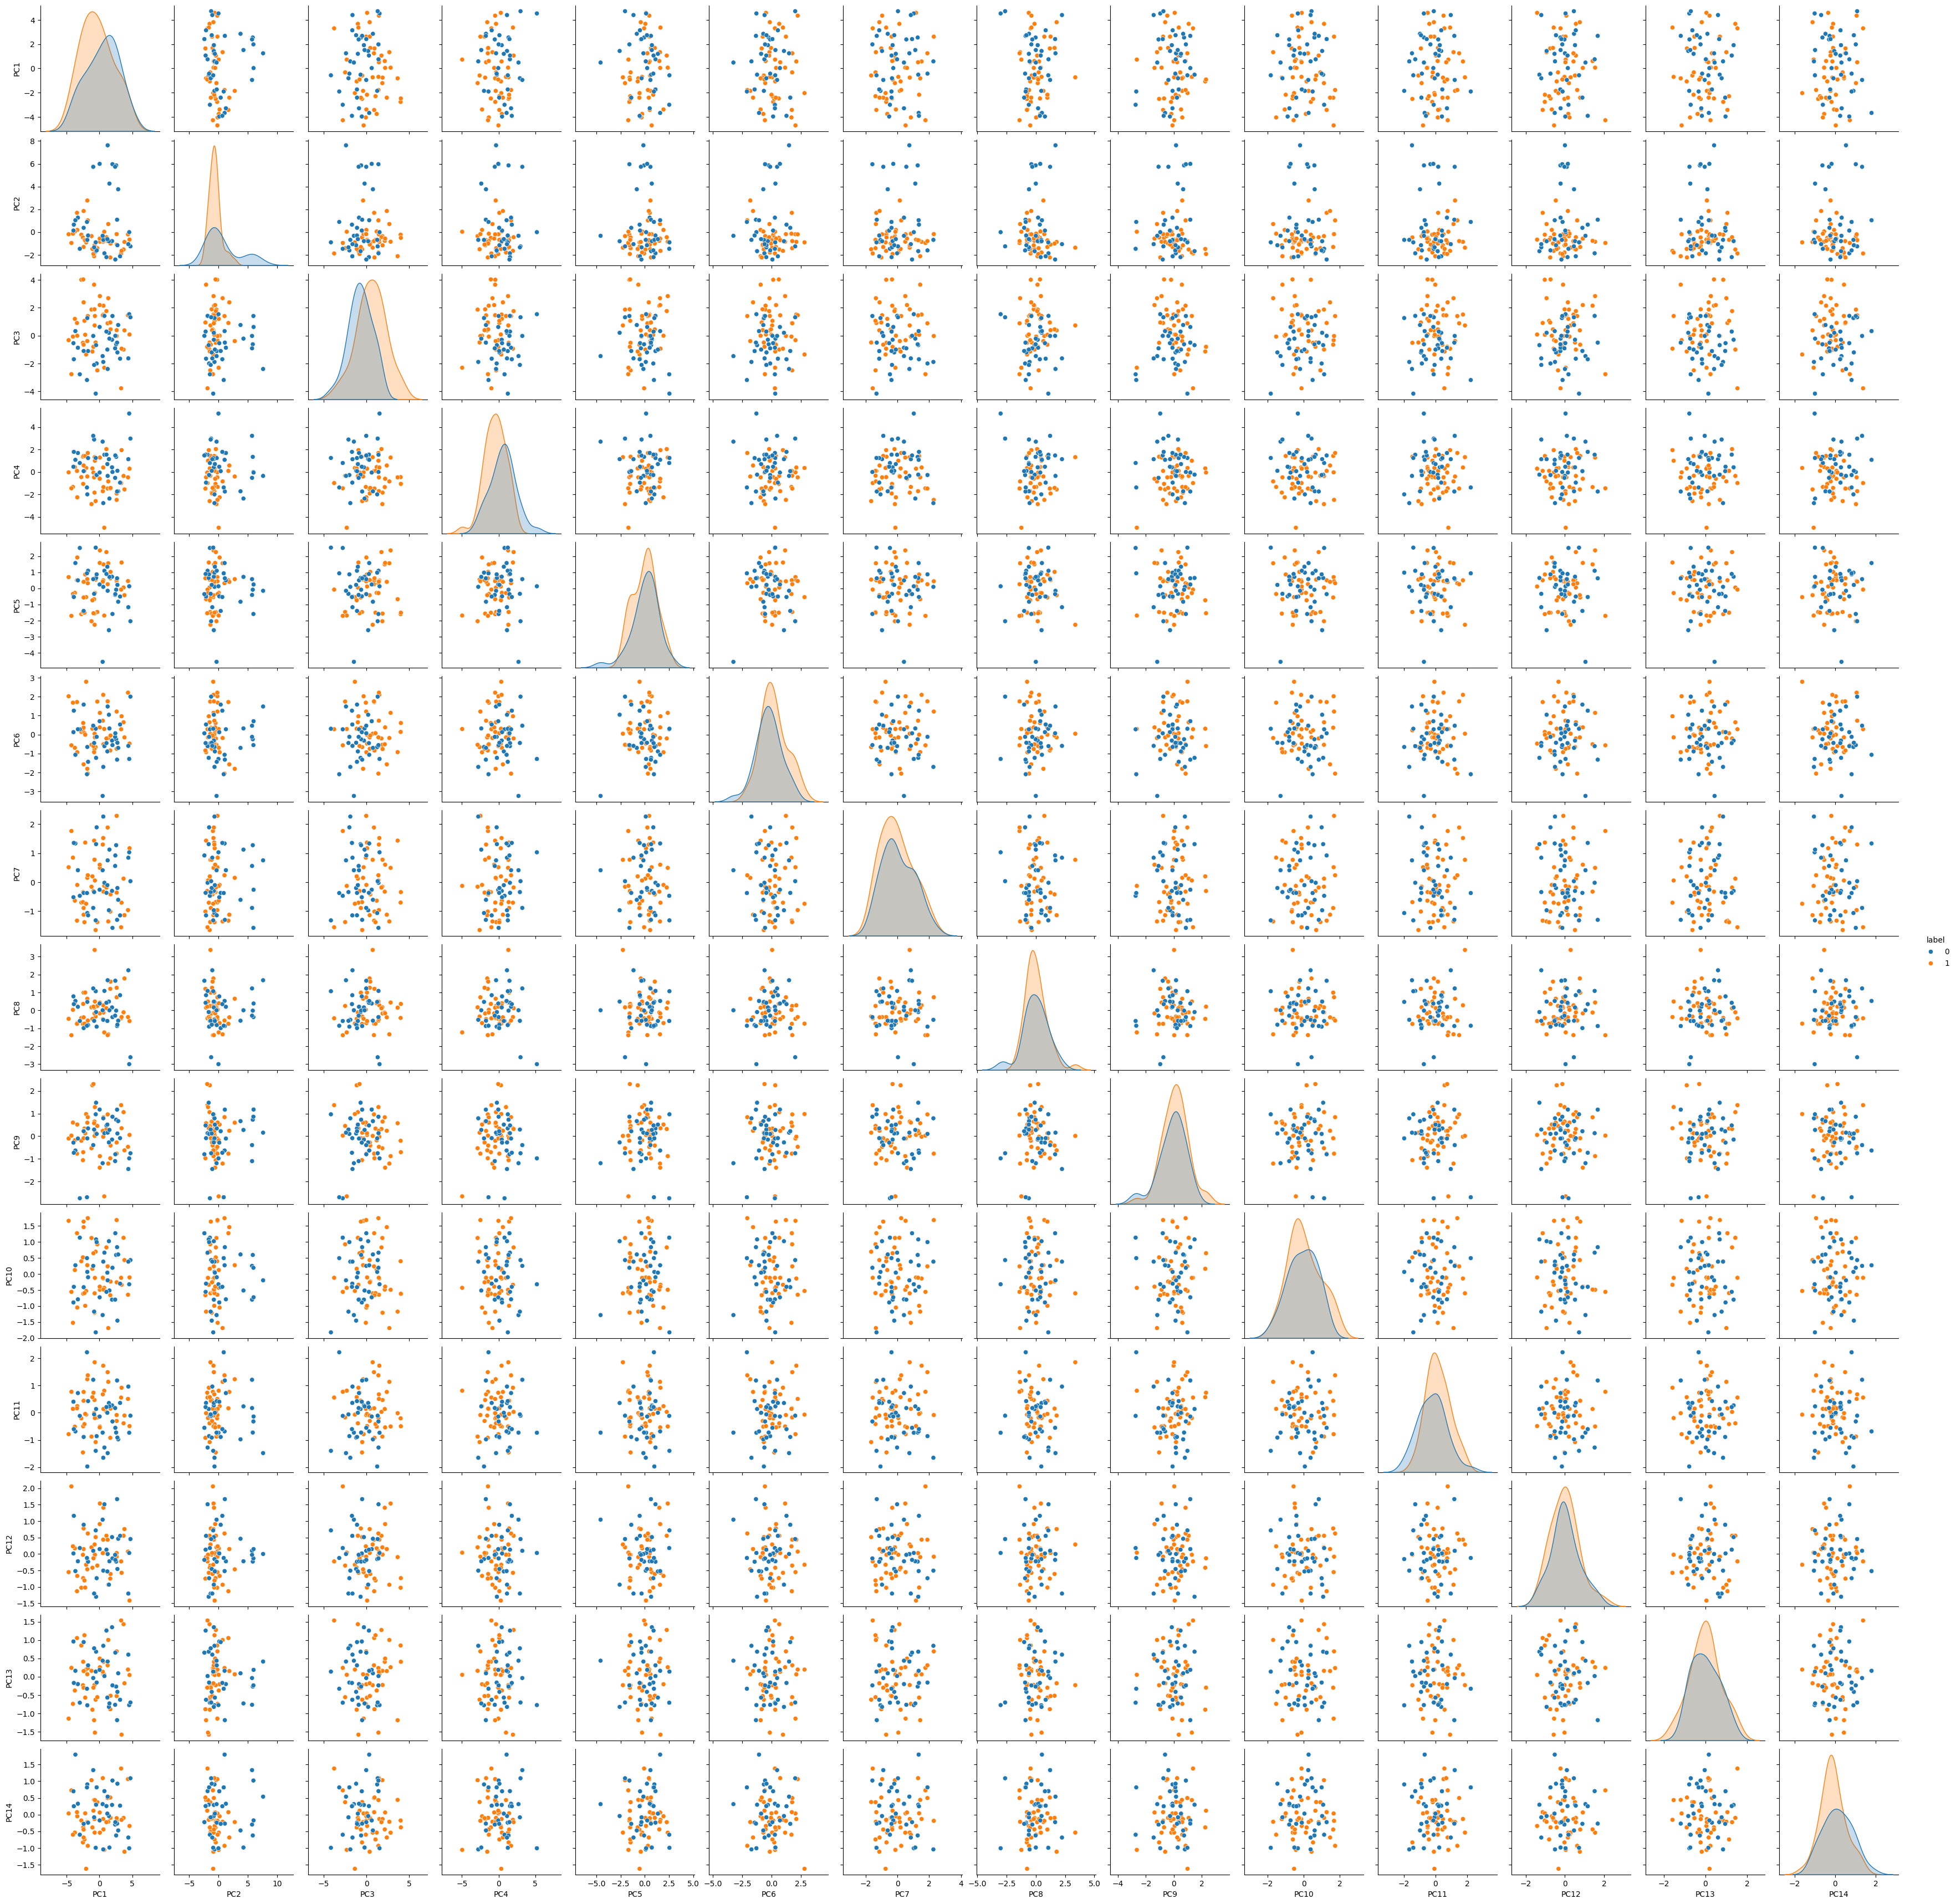

In [4]:
import seaborn as sns
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['label'] = y

sns.pairplot(pca_df, hue='label')
plt.show()

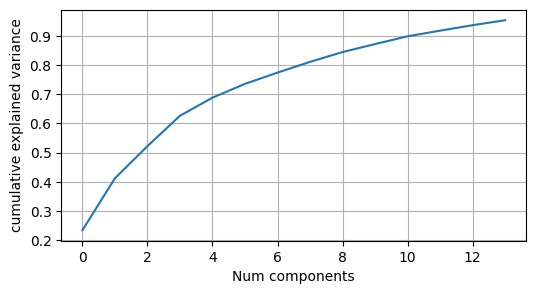

In [5]:
#plotting culminative explained variance
import numpy as np
plt.figure(figsize=(6,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.show()

The cumulative explained variance plot shows that the first 3–5 principal components capture a substantial portion of the variance in the data, with diminishing returns after that point. Specifically, around 70% of the variance is explained by the first 4 components.<br><br> This suggests that much of the data's structure can be represented in a reduced feature space without significant information loss, potentially improving model performance and reducing overfitting risk.

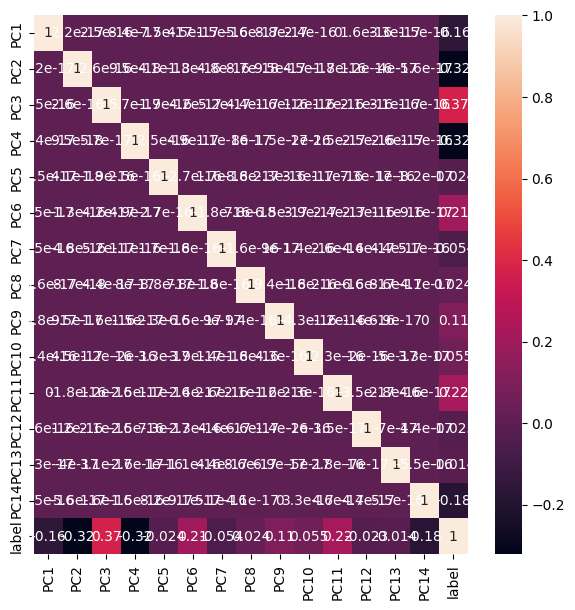

In [6]:
cormap = pca_df.corr()

plt.figure(figsize=(7,7))
sns.heatmap(cormap, annot=True)
plt.show()

<hr>
<h3>Point-Biserial Correlation</h3><br>

Below I will be conducting a Point-Biserial correlation test to select the most informative features, and reduce redundancy, while minimizing the loss of information.

In [7]:
from scipy.stats import pointbiserialr
def PBC(thresh):
#Computing point-biserial p-values for every feature vs. the target
    p_vals = {}
    for col in X.columns:
        _, p = pointbiserialr(X[col], y)
        p_vals[col] = p

    p_series = pd.Series(p_vals)

    #Applying a multiple-testing correction (e.g. Bonferroni)
    alpha = thresh / len(p_series)       #0.08


    pbc_selected = p_series[p_series <= alpha].index.tolist()

    #Filtering the full DataFrame
    return pbc_selected
pbc_selected = PBC(0.08)
pbc_selected 

['f3_mean', 'f2_f1_ratio_mean', 'delta_mean', 'speaking_rate']

The Point-Biserial Correlation test selected the following features:  
- `f3_mean`  
- `f2_f1_ratio_mean`  
- `delta_mean`  
- `speaking_rate`  

These capture relationships among f1, f2, and f3 without heavy collinearity, while including other informative dimensions.  

However, I believe we’re missing a few important predictors:

- **hnr_mean**: According to linguistic theory, harmonics-to-noise ratio is independent of formant values (f1, f2, f3) yet shows a moderate correlation with the target label.  
- **mfcc_1_mean**: MFCCs inherently reflect formant structure but also capture spectral information beyond simple formant metrics. Its collinearity with other features is light enough that an SVM should handle it without issue, and it may provide valuable complementary information.

Therefore, I plan to include `hnr_mean` and `mfcc_1_mean` alongside the point-biserial–selected features to improve model performance.
<hr>

<h2> Machine Learning model development </h2>

<h3> Gaussian Naive Bayes model</h3>

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=67) 


NB_model_base = GaussianNB() #initializing and training model
lr_model_base = LogisticRegression(max_iter=700)
models = [NB_model_base, lr_model_base]
for model in models:
    model.fit(X_train, y_train) 

    base_preds = model.predict(X_test) #creating predictions
    print(f"{model}\n {classification_report(base_preds, y_test)}")

GaussianNB()
               precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.60      0.82      0.69        11

    accuracy                           0.60        20
   macro avg       0.60      0.58      0.56        20
weighted avg       0.60      0.60      0.57        20

LogisticRegression(max_iter=700)
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



In [9]:
mc_validation(NB_model_base, X_pca, y, 1000)

mean accuracy: 0.6455455455455457
standard deviation of scores: 0.09755611140543798


(np.float64(0.6455455455455457), np.float64(0.09755611140543798))

In [10]:
mc_validation(lr_model_base, X_pca, y, 1000)

mean accuracy: 0.7470970970970972
standard deviation of scores: 0.08662612577767073


(np.float64(0.7470970970970972), np.float64(0.08662612577767073))

The naive bayes model has failed to meet the baseline accuracy.

<h3> Support Vector Machine</h3>

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
X_train, X_test, y_train, y_test = train_test_split(df[pbc_selected+['mfcc_1_mean', 'hnr_mean']], y, test_size=0.25, stratify=y, random_state=10)
svc_model = SVC()
param_dist = {
    'C': uniform(0.1,100),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_random_search = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=10
)

svc_random_search.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,SVC()
,param_distributions,"{'C': <scipy.stats....001DB14EF7250>, 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,10
,error_score,nan


In [41]:
print("Best parameters:", svc_random_search.best_params_)
print("Best cross-validated score", svc_random_search.best_score_)

Best parameters: {'C': np.float64(0.4948266327914451), 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated score 0.8303030303030303


In [42]:
svc_best_params = svc_random_search.best_params_
tuned_svc = SVC(**svc_best_params)
tuned_svc.fit(X_train,y_train)
svc_preds = tuned_svc.predict(X_test)
print(classification_report(svc_preds, y_test))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.73      0.73      0.73        11

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



In [43]:
mc_validation(tuned_svc,df[pbc_selected+['mfcc_1_mean', 'hnr_mean']],y, 300)

mean accuracy: 0.7797658862876254
standard deviation of scores: 0.08742093632052701


(np.float64(0.7797658862876254), np.float64(0.08742093632052701))

In [44]:
import joblib

#saving the best model from the RadomSearch
best_svc_model  = svc_random_search.best_estimator_
joblib.dump(best_svc_model, 'svc_model.pkl')

['svc_model.pkl']

The SVC model barely exceeded the baseline, and will be selected as the best model so far